# Import & Config

In [1]:
import pandas as pd
import numpy as np
import copy
import itertools
import os
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import linprog
import math
import scipy.stats
from scipy.spatial import KDTree
import tqdm
import re

# Implementation Most Recent


In [2]:
# Test Case
n = 5 # Size of ground set U = {0, 1, 2, ..., n}
sets = [
    {0, 1},
    {0, 2},
    {0, 3},
    {0, 4},
    {0, 4, 1},
    {0, 1}
]
colors = [0, 0, 1, 1, 1, 1] # 0 --> red, 1 --> blue
m = len(sets) # Number of sets

In [3]:
def get_point_to_set_hashmap(sets):
    print("point -> set")
    point_to_sets = {}
    for i, s in enumerate(tqdm.tqdm(sets)):
        for point in s:
            if point not in point_to_sets.keys():
                point_to_sets[point] = []
            point_to_sets[point].append(i)
    return point_to_sets

def get_color_to_set_hashmap(sets, colors):
    print("color -> set")
    color_to_sets = {}
    for i, s in enumerate(tqdm.tqdm(sets)):
        if colors[i] not in color_to_sets.keys():
            color_to_sets[colors[i]] = []
        color_to_sets[colors[i]].append(i)
    return color_to_sets

## Greedy Standard

In [4]:
# Greedy
def standard_set_cover(n, sets):
    # Pre-process
    sets = copy.deepcopy(sets)
    point_to_sets = get_point_to_set_hashmap(sets)

    cover = []
    counter = 0

    # Main Loop
    while True:
        print(f"standard_set_cover set {counter + 1} / {len(sets)}", end="\r")
        counter += 1
        # Find largest set
        largest_set = np.argmax([len(s) for s in sets])

        # Break if all points are covered
        if len(sets[largest_set]) == 0:
            break

        # Add to cover
        cover.append(largest_set)

        # Remove covered ones
        for covered_point in tqdm.tqdm(copy.deepcopy(sets[largest_set])):
            for i in point_to_sets[covered_point]:
                covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# standard_set_cover(n, sets)

## Naive Fair

In [5]:
def naive_fair_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    unfair_cover = standard_set_cover(n, copy.deepcopy(sets))

    # Add arbitrary sets from other colors
    cover_colors, color_counts = np.unique([colors[s] for s in unfair_cover], return_counts=True)
    max_color = max(color_counts)
    for color in tqdm.tqdm(color_to_sets.keys()):
        if color in cover_colors:
            to_add = max_color - color_counts[cover_colors.tolist().index(color)]
        else:
            to_add = max_color

        cand_sets = color_to_sets[color]
        # print(f"color: {color}, size: {len(cand_sets)}, to_add: {to_add}, cover_len: {len(unfair_cover)}")
        index = 0
        while to_add > 0:
            if cand_sets[index] not in unfair_cover:
                unfair_cover.append(cand_sets[index])
                to_add -= 1
            index += 1

    return unfair_cover

# naive_fair_set_cover(n, sets, colors)

## All Pick

In [6]:
def permute(list, per, position, all):
    if position == len(list):
        all.append(per)
    else:
        for i in range(list[position]):
            tmp = copy.deepcopy(per)
            tmp[position] = i
            permute(list, tmp, position + 1, all)

final = []
permute([39, 32, 29], [0, 0, 0], 0, final)
print(final[29 * 31 + 20 + 8])

[0, 31, 28]


In [7]:
'''
Find fair max cover by picking a pair at each step.
Checks all possible pairs at each step.
'''
def all_pick_fair_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    keys = [i for i in range(len(color_to_sets.keys()))]
    sets_picked = [False for _ in range(len(sets))]

    # Main Loop
    while True:
        # Find Largest Pair
        max_union = len(set().union(*[sets[color_to_sets[key][0]] for key in keys]))
        picked_pair = tuple([color_to_sets[key][0] for key in keys])

        all_permutes = []
        permute(
            [len(color_to_sets[i]) for i in keys],
            [0 for _ in keys],
            0,
            all_permutes
        )

        for pair in all_permutes:
            union = len(set().union(*[sets[color_to_sets[i][j]] for i, j in enumerate(pair)]))
            if union > max_union:
                max_union = union
                picked_pair = tuple([color_to_sets[i][j] for i, j in enumerate(pair)])

        # Break if all points covered
        if max_union == 0:
            break

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# all_pick_fair_set_cover(n, sets, colors)

## Efficient All Pick

In [8]:
def approx_best_pair(sets, point_to_sets, color_to_sets, n, m, covered, sets_picked):
    '''
    max sum(y_j)
        sum(x_i) >= y_j; for each y_j,
        sum(x_i) = 1; for each color,
        0 <= y_j <= 1,
        0 <= x_i <= 1
    '''
    # [y_1, ..., y_n, x_1, ..., x_m]
    c = [0 for i in range(m)] + [-1 for j in range(n)]
    C1 = []
    for j in range(n):
        if covered[j]:
            continue
        c1 = [0 for i in range(m + n)]
        s = point_to_sets[j]
        c1[j + m] = 1
        for i in s:
            c1[i] = -1
        C1.append(c1)

    C2 = []
    C3 = []
    for color in color_to_sets.keys():
        c2 = [0 for i in range(m + n)]
        c3 = [0 for i in range(m + n)]
        s = color_to_sets[color]
        for i in s:
            if sets_picked[i]:
                continue
            c2[i] = 1
            c3[i] = -1
        C2.append(c2)
        C3.append(c3)

    b = [0 for _ in range(len(C1))] + [1 for _ in range(len(color_to_sets))] + [-1 for _ in range(len(color_to_sets))]
    bounds = [(0, 1) for _ in range(n + m)]

    A = C1 + C2 + C3

    res = linprog(c=c, A_ub=A, b_ub=b, bounds=bounds)

    return res

In [9]:
'''
Find fair max cover by picking a pair at each step.
Finds an approximation of best possible pair by rounding an LP
'''
def efficient_pick_set_cover(n, sets, colors):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    points_covered = [False for _ in range(n)]
    sets_picked = [False for _ in range(len(sets))]
    m = len(sets)
    keys = [i for i in range(len(color_to_sets.keys()))]

    counter = 0
    # Main Loop
    while True:
        print(f"Efficient pick set {counter + 1} / {len(sets)}", end="\r")
        counter += 1
        # Break if all points covered
        if np.all(points_covered):
            break

        # Find Largest Pair
        res = approx_best_pair(
            sets,
            point_to_sets,
            color_to_sets,
            n,
            m,
            points_covered,
            sets_picked
        )
        picked_pair = tuple([
            np.random.choice(color_to_sets[i], 1, p=res.x[:m][color_to_sets[i]])[0]
            for i in keys
        ])

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in tqdm.tqdm(picked_pair):
            for covered_point in copy.deepcopy(sets[p]):
                points_covered[covered_point] = True
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

# efficient_pick_set_cover(n, sets, colors)

# Pospim Dataset

In [10]:
with open("dataset/input_database.txt", 'r') as f:
    lines = f.readlines()
len(lines)

4110618

In [11]:
coord = re.compile(r"\((\d+.\d+),\s(\d+.\d+)\)")
color = re.compile(r"(\d)")

data = {}
last_c = None
for line in lines:
    if coord.match(line):
        # print(re.search(coord, line).group(2), line)
        match = re.search(coord, line)
        x, y = float(match.group(1)), float(match.group(2))
        data[last_c].append((x, y))
    elif color.match(line):
        # print(re.findall(color, line), line)
        c = int(line.strip())
        data[c] = []
        last_c = c


In [12]:
df = {
    "color": [],
    "x": [],
    "y": []
}

for key in data.keys():
    for point in data[key]:
        df["color"].append(key)
        df["x"].append(point[0])
        df["y"].append(point[1])

data = pd.DataFrame(df)
data.head()

,color,x,y
0,0,7720.982199,78867.188540
1,0,89627.028825,70071.537547
2,0,84361.871932,97117.551705
3,0,28595.067689,87388.534848
4,0,79024.626051,66595.629925


In [13]:
data = data[data["color"] > 0]
data["color"] = data["color"].replace({1: 0, 2: 1, 3: 2, 4: 3})
data["color"].value_counts(), data.shape

(color
 3    3070882
 2     705193
 1     294728
 0      38080
 Name: count, dtype: int64,
 (4108883, 3))

## Make Sets v1

In [14]:
df = data.sample(n=100000)
# df = data.copy()
df = df.reset_index()
df["color"].value_counts(), df.head()

(color
 3    74582
 2    17195
 1     7314
 0      909
 Name: count, dtype: int64,
      index  color             x             y
 0  1472510      3  83970.249450  84385.472050
 1  2665300      3  95403.872611  79465.585964
 2  1236124      3  89766.470398  69138.336054
 3  3993687      3  61112.716471  49047.979972
 4  1175349      3  86200.728902  94579.365992)

In [15]:
circle_radius = 10000

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def get_all_within_distance(p, radius, df):
    for index, p2 in df.iterrows():
        if distance((p["x"], p["y"]), (p2["x"], p2["y"])) <= radius:
            yield index

# Return sets, colors
def make_sets(df, circle_radius=circle_radius):
    sets = []
    colors = []
    for index, point in df.iterrows():
        print (f"Making sets: {index + 1} / {df.shape[0]}", end="\r")
        # if index % 10 == 0:
        #     print(f"{index} / {df.shape[0]}")
        colors.append(point["color"])
        neighbors = list(get_all_within_distance(point, circle_radius, df))
        sets.append(set(neighbors))
    
    return sets, colors

def make_sets_v2(df, circle_radius, set_sample_size):
    sets = []
    colors = []
    tree = KDTree(df[["x", "y"]])
    result = tree.query_ball_point(df[["x", "y"]].sample(n=set_sample_size), r=circle_radius, workers=12)
    
    for i, s in enumerate(result):
        print(f"Making sets: {i + 1} / {set_sample_size}", end="\r")
        point = df.iloc[i]
        colors.append(point["color"])
        sets.append(s)

    return sets, colors

# sets, colors = make_sets(df)
# sets, colors = make_sets_v2(df)

In [16]:
gc.collect()

0

In [17]:
def verify_sets(sets, N, colors):
    for i in range(N):
        print(f"Verifying {i + 1} / {N}", end="\r")
        flag = False
        for s in sets:
            if i in s:
                flag = True
        if not flag:
            print(i)
            return False
    if len(np.unique(colors)) < 4:
        return False
    return True

from itertools import chain

def verify_sets_v2(sets, N, colors):
    all_sets = set()
    # for i, s in enumerate(sets):
    #     print(f"Appending sets {i + 1} / {len(sets)}", end="\r")
    #     all_sets = all_sets.union(set(s))
    # all_sets = list(set().union(*sets))

    all_sets = list(set(chain.from_iterable(sets)))
    print("")
    for i in range(N):
        print(f"Verifying {i + 1} / {N}", end="\r")
        if i not in all_sets:
            return False
    if len(np.unique(colors)) < 4:
        return False
    
     # Enrich the sets!
    for i in range(4):
        col_ind = colors.index(i)
        for _ in range(10): # Add 10 of each
            sets.append(sets[col_ind])
            colors.append(i)

    return True


# verify_sets(sets, df.shape[0], colors)
# verify_sets_v2(sets, df.shape[0], colors)

## Sample Run for figure

In [116]:
N = set_size = 1000
circle_radius = 25000
while True:
    while True:
        print("Sampling...")
        df = data.sample(n=set_size)
        df = df.reset_index()
        # if len(np.unique(colors)) < 4:
        #     print("Invalid colors...")
        #     continue
        print("Making sets...")
        sets, colors = make_sets(df, circle_radius=circle_radius)
        if verify_sets(sets, N, colors):
            break
    try:
        res_1 = naive_fair_set_cover(N, sets, colors)
        res_2 = efficient_pick_set_cover(N, sets, colors)
        break
    except:
        print("Retrying...")

Sampling...
Making sets...


In [135]:
res_3 = standard_set_cover(N, sets)

In [117]:
len(res_2)

12

In [138]:
df["color"].value_counts()

color
3    741
2    179
1     66
0     14
Name: count, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


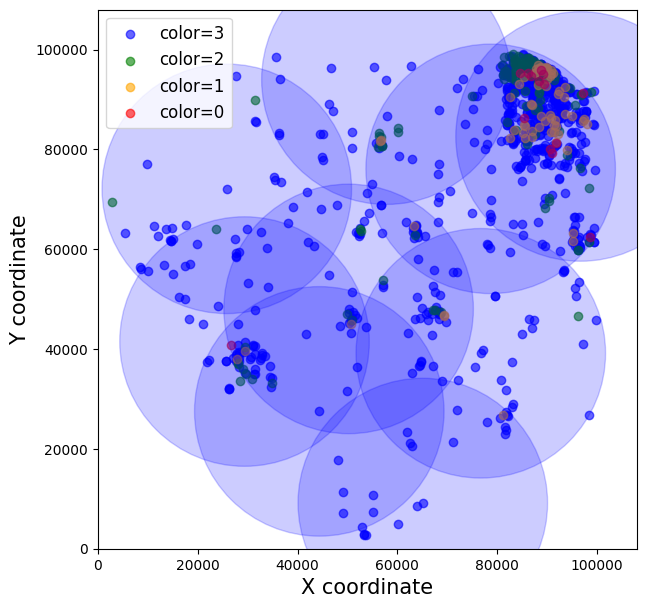

In [137]:
fig, ax = plt.subplots(figsize=(7, 7))

colors_value = ["red", "orange", "green", "blue"]

ax.scatter(x=df[df["color"] == 3]["x"], 
           y=df[df["color"] == 3]["y"], 
           label="color=3", 
           c=colors_value[3],
           alpha=0.6)
ax.scatter(x=df[df["color"] == 2]["x"], 
           y=df[df["color"] == 2]["y"], 
           label="color=2", 
           c=colors_value[2],
           alpha=0.6)
ax.scatter(x=df[df["color"] == 1]["x"], 
           y=df[df["color"] == 1]["y"], 
           label="color=1", 
           c=colors_value[1],
           alpha=0.6)
ax.scatter(x=df[df["color"] == 0]["x"], 
           y=df[df["color"] == 0]["y"], 
           label="color=0", 
           c=colors_value[0],
           alpha=0.6)
ax.legend(prop={'size': 12})

for result in sorted(res_3, reverse=True):
    point = df.iloc[result]
    circle1 = plt.Circle((point["x"], point["y"]), circle_radius, color=colors_value[int(point["color"])], alpha=0.2)
    ax.add_patch(circle1)

ax.set_aspect('equal', adjustable='box')
ax.set_ylim(0, 108000)
ax.set_xlim(0, 108000)

plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)

# plt.savefig('popsim_vis_standard.png', bbox_inches='tight')
# plt.savefig('popsim_vis_standard.eps', format="eps")

plt.show()

In [53]:
lens = []
for x in sets:
    lens.append(len(x))
tmp = pd.Series(lens)
tmp.min(), tmp.max(), tmp.mean()

(1, 259, 112.932)

## Experiment

In [18]:
def run_with_time(func, *args):
    start_time = time.time()
    res = func(*args)
    run_time = time.time() - start_time
    return (res, run_time)

def run_all(n, sets, colors):
    results = {}

    print("\nEffAllPick...")
    results["EffAllPick"] = run_with_time(efficient_pick_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("\nNaive...")
    results["Naive"] = run_with_time(naive_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("\nSC...")
    results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    
    # print("AllPick...")
    # results["AllPick"] = run_with_time(all_pick_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    gc.collect()

    return results

In [ ]:
runs_per_n = 5
# set_sizes = [20000, 40000, 60000, 80000, 100000]
# set_sizes = [10_000, 12_000, 14_000, 16_000, 18_000, 20_000]
set_sizes = [2_000, 4_000, 6_000, 8_000]

output_file_name_times = "output_popsim_times_v2.0_1k.txt"
output_file_name_counts = "output_popsim_counts_v2.0_1k.txt"
output_file_name_fairness = "output_popsim_fairness_v2.0_1k.txt"

# result_df_times = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
# result_df_counts = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
# result_df_fairness = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
result_df_times = {"SetSize": [], "SC": [], "Naive": [], "EffAllPick": []}
result_df_counts = {"SetSize": [], "SC": [], "Naive": [], "EffAllPick": []}
result_df_fairness = {"SetSize": [], "SC": [], "Naive": [], "EffAllPick": []}

try:
    os.remove(output_file_name_counts)
    os.remove(output_file_name_times)
    os.remove(output_file_name_fairness)
except OSError:
    pass

for set_size in set_sizes:
    N = set_size
    for i in range(runs_per_n):
        print(f"Sample {i + 1} / {runs_per_n}")
        
        while True:
            while True:
                df = data.sample(n=set_size)
                df = df.reset_index()
                sets, colors = make_sets_v2(df, circle_radius=20000, set_sample_size=set_size // 10)
                # Sampling a subset of sets!
                # sets, colors = zip(*random.sample(list(zip(sets, colors)), 5000))
                print(f"\n set & color size {len(sets)} - {len(colors)}")
                if verify_sets_v2(sets, N, colors):
                    break
                else:
                    print("\nnot verified, retrying...")

            print("\nRunning...")
            
            # Run
            try:
                result = run_all(N, sets, colors)
                gc.collect() # remove unused memory!
                break
            except Exception as e:
                print("\nIndexError retrying...", e)
                continue


        print(f"\nset_size = {set_size} in {set_sizes} : {i + 1} / {runs_per_n}")

        # Generate Result Dataframe
        fair_res = []
        count_res = []
        times_res = []

        result_df_times["SetSize"].append(set_size)
        times_res.append(set_size)
        result_df_counts["SetSize"].append(set_size)
        count_res.append(set_size)
        result_df_fairness["SetSize"].append(set_size)
        fair_res.append(set_size)
        for key in result:
            result_df_times[key].append(result[key][1])
            times_res.append(result[key][1])
            result_df_counts[key].append(len(result[key][0]))
            count_res.append(len(result[key][0]))
            tmp = np.unique([colors[c] for c in result[key][0]], return_counts=True)[1]
            if len(tmp) == 1:
                result_df_fairness[key].append(0)
                fair_res.append(0)
            else:
                result_df_fairness[key].append(np.min(tmp) / np.max(tmp))
                fair_res.append(np.min(tmp) / np.max(tmp))

        # Write files
        with open(output_file_name_counts, "a") as f:
            f.writelines(",".join([str(x) for x in count_res]) + "\n")
        with open(output_file_name_fairness, "a") as f:
            f.writelines(",".join([str(x) for x in fair_res]) + "\n")
        with open(output_file_name_times, "a") as f:
            f.writelines(",".join([str(x) for x in times_res]) + "\n")

result_df_times = pd.DataFrame(result_df_times)
result_df_counts = pd.DataFrame(result_df_counts)
result_df_fairness = pd.DataFrame(result_df_fairness)

result_df_counts.to_csv(f"result_df_counts_popsim_1k.csv")
result_df_fairness.to_csv(f"result_df_fairness_popsim_1k.csv")
result_df_times.to_csv(f"result_df_times_popsim_1k.csv")

# Adult Dataset

In [139]:
data = pd.read_csv("dataset/adult.csv")
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [140]:
data.shape, data["gender"].value_counts()

((48842, 15),
 gender
 Male      32650
 Female    16192
 Name: count, dtype: int64)

In [241]:
df = data.sample(n=4000)

In [189]:
cover_columns = {
    "workclass": ["Private", "Self-emp-not-inc", "Local-gov", "State-gov", "Self-emp-inc", "Federal-gov"], 
    "education": ["HS-grad", "Some-college", "Bachelors", "Masters", "Assoc-voc", "11th", "Assoc-acdm", "10th", "7th-8th"], 
    "marital-status": ["Married-civ-spouse", "Never-married", "Divorced", "Widowed"], 
    "occupation": ["Craft-repair", "Adm-clerical", "Prof-specialty", "Exec-managerial", "Sales", "Other-service", "Machine-op-inspct", "Transport-moving"], 
    "income": ["<=50K", ">50K"]
}

In [190]:
df["income"].value_counts()

income
<=50K    3046
>50K      954
Name: count, dtype: int64

In [242]:
# Assign numbers to points
points = []
for k in cover_columns.keys():
    points += cover_columns[k]
print(len(points))

28


In [ ]:
# Make the sets
# Returns: sets, colors
def make_sets(data, cover_columns, points):
    sets = []
    colors = []
    for index, row in data.iterrows():
        this_set = []
        for col in cover_columns.keys():
            if row[col] in points:
                this_set.append(points.index(row[col]))
        sets.append(set(this_set))
        colors.append(1 if row["gender"] == "Male" else 0)
    return sets, colors

sets, colors = make_sets(df, cover_columns, points)
len(sets), len(colors)

In [193]:
np.unique(np.array(colors), return_counts=True), df["gender"].value_counts()

((array([0, 1]), array([1321, 2679])),
 gender
 Male      2679
 Female    1321
 Name: count, dtype: int64)

## Experiment

In [194]:
def run_with_time(func, *args):
    start_time = time.time()
    res = func(*args)
    run_time = time.time() - start_time
    return (res, run_time)

def run_all(n, sets, colors):
    results = {}

    print("SC...")
    results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    print("Naive...")
    results["Naive"] = run_with_time(naive_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("AllPick...")
    results["AllPick"] = run_with_time(all_pick_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("EffAllPick...")
    results["EffAllPick"] = run_with_time(efficient_pick_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))

    return results

In [200]:
runs_per_n = 5
N = len(points)
set_sizes = [1000, 2000, 3000, 4000, 5000]

result_df_times = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
result_df_counts = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
result_df_fairness = {"SetSize": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}

for set_size in set_sizes:
    for i in range(runs_per_n):
        print("Preparing the sets")
        
        df = data.sample(n=set_size)
        sets, colors = make_sets(df, cover_columns, points)

        print("Running...")
        
        # Run
        result = run_all(N, sets, colors)

        print(f"set_size = {set_size} in {set_sizes} : {i + 1} / {runs_per_n}")

        # Generate Result Dataframe
        result_df_times["SetSize"].append(set_size)
        result_df_counts["SetSize"].append(set_size)
        result_df_fairness["SetSize"].append(set_size)
        for key in result:
            result_df_times[key].append(result[key][1])
            result_df_counts[key].append(len(result[key][0]))
            tmp = np.unique([colors[c] for c in result[key][0]], return_counts=True)[1]
            if len(tmp) == 1:
                result_df_fairness[key].append(0)
            else:
                result_df_fairness[key].append(np.min(tmp) / np.max(tmp))


result_df_times = pd.DataFrame(result_df_times)
result_df_counts = pd.DataFrame(result_df_counts)
result_df_fairness = pd.DataFrame(result_df_fairness)

Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 1000 in [1000, 2000, 3000, 4000, 5000] : 1 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 1000 in [1000, 2000, 3000, 4000, 5000] : 2 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 1000 in [1000, 2000, 3000, 4000, 5000] : 3 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 1000 in [1000, 2000, 3000, 4000, 5000] : 4 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 1000 in [1000, 2000, 3000, 4000, 5000] : 5 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 2000 in [1000, 2000, 3000, 4000, 5000] : 1 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 2000 in [1000, 2000, 3000, 4000, 5000] : 2 / 5
Preparing the sets
Running...
SC...
Naive...
AllPick...
EffAllPick...
set_size = 2000 in [1000, 2000, 30

## Generalized

In [10]:
def gen_permute(list, per, constraint, position, all, starts):
    if position == len(list):
        all.append(per)
    else:
        for i in range(starts[constraint[position]], list[position]):
            tmp = copy.deepcopy(per)
            s = copy.deepcopy(starts)
            s[constraint[position]] = i + 1
            tmp[position] = i
            gen_permute(list, tmp, constraint, position + 1, all, s)

final = []
# gen_permute([40, 40, 40, 40, 40], [0, 0, 0, 0, 0], [0, 1, 1, 1, 1], 0, final, [0, 0])
# [101, 99, 99, 99, 99], [0, 0, 0, 0, 0], [0, 1, 1, 1, 1]
# final

In [11]:
from itertools import product, combinations

def permute_eff(extended_colors, color_to_sets):
    combs = [combinations(color_to_sets[c], extended_colors.count(c)) for c in range(len(color_to_sets.keys()))]
    for pair in product(*combs):
        a = []
        [a.extend([s for s in p]) for p in pair]
        print(a)

permute_eff(extended_colors=[1, 0, 0], color_to_sets={1: {1, 2, 3}, 0: {4, 5, 6}})

[4, 5, 1]
[4, 5, 2]
[4, 5, 3]
[4, 6, 1]
[4, 6, 2]
[4, 6, 3]
[5, 6, 1]
[5, 6, 2]
[5, 6, 3]


In [12]:
def get_extended_colors(ratios, L):
    ratios = [int(x * L) for x in ratios]
    gcd = math.gcd(*ratios)
    ratios = [x // gcd for x in ratios]
    # return ratios
    extended_colors = []
    for i, rate in enumerate(ratios):
        extended_colors += [i for _ in range(rate)]

    return extended_colors


get_extended_colors([0.1, 0.2, 0.7], 1000)

[0, 1, 1, 2, 2, 2, 2, 2, 2, 2]

In [13]:
def generalized_all_pick(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    keys = [i for i in range(len(color_to_sets.keys()))]
    sets_picked = [False for _ in range(len(sets))]
    extend_colors = get_extended_colors(ratios, 1000)

    # Main Loop
    while True:
        # Find Largest Pair
        max_union = None
        picked_pair = None
        # for c in keys:
        #     picked_pair += color_to_sets[c][:extend_colors.count(c)]

        # max_union = len(set().union(*[sets[s] for s in picked_pair]))
        # picked_pair = tuple(picked_pair)
        # print(picked_pair, max_union, [sets[s] for s in picked_pair])
        # break

        all_permutes = []
        print(f"Start of comb: {[len(color_to_sets[i]) for i in extend_colors], [0 for _ in extend_colors], extend_colors}")
        # gen_permute(
        #     [len(color_to_sets[i]) for i in extend_colors],
        #     [0 for _ in extend_colors],
        #     extend_colors,
        #     0,
        #     all_permutes,
        #     [0 for _ in keys]
        # )
        # print("end")

        combs = [combinations(list(filter(lambda x: len(sets[x]) > 0, color_to_sets[c])), extend_colors.count(c)) for c in range(len(color_to_sets))]
        print("end")
        updated = False
        for pair in product(*combs):
            tmp = []
            [tmp.extend([s for s in p]) for p in pair]
            pair = tmp
            union = len(set().union(*[sets[s] for s in pair]))
            if max_union is None or union > max_union:
                updated = True
                max_union = union
                picked_pair = tuple(pair)

        # Break if all points covered
        if max_union == 0 or max_union is None:
            break

        # Not Found!
        # if not updated:
        #     return []

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

generalized_all_pick(n, sets, colors, [0.6, 0.3])

Start of comb: ([2, 2, 4], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([2, 2, 4], [0, 0, 0], [0, 0, 1])
end


[0, 1, 2]

In [14]:
def gen_LP(sets, point_to_sets, color_to_sets, n, m, covered, sets_picked, p_stars):
    '''
    max sum(y_j)
        sum(x_i) >= y_j; for each y_j,
        sum(x_i) = 1; for each color,
        0 <= y_j <= 1,
        0 <= x_i <= 1
    '''
    # [y_1, ..., y_n, x_1, ..., x_m]
    c = [0 for i in range(m)] + [-1 for j in range(n)]
    C1 = []
    for j in range(n):
        if covered[j]:
            continue
        c1 = [0 for i in range(m + n)]
        s = point_to_sets[j]
        c1[j + m] = 1
        for i in s:
            c1[i] = -1
        C1.append(c1)

    C2 = []
    C3 = []
    for color in range(len(color_to_sets.keys())):
        # print("c: ", color)
        c2 = [0 for i in range(m + n)]
        c3 = [0 for i in range(m + n)]
        s = color_to_sets[color]
        for i in s:
            if sets_picked[i]:
                continue
            c2[i] = 1
            c3[i] = -1
        C2.append(c2)
        C3.append(c3)

    b = [0 for _ in range(len(C1))] + [p for p in p_stars] + [-p for p in p_stars]
    bounds = [(0, 1) for _ in range(n + m)]

    A = C1 + C2 + C3

    res = linprog(c=c, A_ub=A, b_ub=b, bounds=bounds)

    return res

def eff_gen_pick(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    cover = []
    points_covered = [False for _ in range(n)]
    sets_picked = [False for _ in range(len(sets))]
    m = len(sets)
    keys = [i for i in range(len(color_to_sets.keys()))]
    extend_colors = get_extended_colors(ratios, 1000)
    p_stars = [extend_colors.count(color) for color in keys]
    # print(p_stars)

    # Main Loop
    while True:
        # Break if all points covered
        if np.all(points_covered):
            break

        # Find Largest Pair
        res = gen_LP(
            sets,
            point_to_sets,
            color_to_sets,
            n,
            m,
            points_covered,
            sets_picked,
            p_stars
        )
        if not res.success:
            break
        picked_pair = []
        for i in keys:
            # print("unique: ", np.unique(res.x[:m], return_counts=True), "desired count: ", p_stars[i], "0 count: ", np.unique(res.x[:m][color_to_sets[0]], return_counts=True), "1 count: ", np.unique(res.x[:m][color_to_sets[1]], return_counts=True))
            cans = [*np.random.choice(color_to_sets[i], size=p_stars[i], p=res.x[:m][color_to_sets[i]]/sum(res.x[:m][color_to_sets[i]]), replace=False)]
            # print(np.unique(np.array(cans)), cans)
            uni = np.unique(np.array(cans))
            cans = [i for i in uni]
            if len(uni) < p_stars[i]:
                ind = 0
                for s in color_to_sets[i]:
                    if ind == p_stars[i] - len(uni):
                        break
                    if not sets_picked[s] and not s in picked_pair and not s in cans:
                        cans.append(s)
                        ind += 1

            picked_pair += cans

        # print(picked_pair)

        # Add to cover
        cover += [*picked_pair]
        for p in picked_pair:
            sets_picked[p] = True

        # Remove covered points
        for p in picked_pair:
            for covered_point in copy.deepcopy(sets[p]):
                points_covered[covered_point] = True
                for i in point_to_sets[covered_point]:
                    covered_point in sets[i] and sets[i].remove(covered_point)

    return cover

eff_gen_pick(n, sets, colors, [0.6, 0.3])

[0, 1, 2]

In [15]:
# Two color case!
def naive_generalized(n, sets, colors, ratios):
    # Pre-process
    sets = copy.deepcopy(sets)
    colors = copy.deepcopy(colors)
    point_to_sets = get_point_to_set_hashmap(sets)
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    unfair_cover = standard_set_cover(n, copy.deepcopy(sets))
    extended = get_extended_colors(ratios, 1000)

    # Add arbitrary sets from other colors
    cover_colors, color_counts = np.unique([colors[s] for s in unfair_cover], return_counts=True)
    # print(cover_colors)
    # print(color_counts)
    # print(extended)
    min_rate, c = min([(extended.count(c) / color_counts[cover_colors.tolist().index(c)], c) for c in range(len(color_to_sets.keys()))], key=lambda x: x[0])
    min_rate = math.ceil(min_rate)
    extended *= int(math.lcm(extended.count(c), color_counts[cover_colors.tolist().index(c)]) / extended.count(c))

    for color in color_to_sets.keys():
        if color in cover_colors:
            to_add = extended.count(color) - color_counts[cover_colors.tolist().index(color)]
        else:
            to_add = extended.count(color)

        cand_sets = color_to_sets[color]
        index = 0
        while to_add > 0:
            if cand_sets[index] not in unfair_cover:
                unfair_cover.append(cand_sets[index])
                to_add -= 1
            index += 1

    return unfair_cover

naive_generalized(n, sets, colors, ratios=[0.3, 0.6])

[4, 1, 2]

## Opt

### Standard Solution

In [41]:
def opt_standard_solution(n, sets, max_length):
    for cover_size in range(max_length + 1):
        for cover in itertools.combinations(sets, cover_size):
            union = set().union(*cover)
            if len(union) == n:
                return [sets.index(c) for c in cover]

opt_standard_solution(n, sets, max_length=4)

[1, 2, 4]

### Fair Solution

In [42]:
def opt_fair_solution(n, sets, colors, max_length):
    color_to_sets = get_color_to_set_hashmap(sets, colors)
    blue_sets = color_to_sets[0]
    red_sets = color_to_sets[1]

    for cover_size in range(2, max_length + 2, 2):
        for blue in itertools.combinations(blue_sets, cover_size // 2):
            for red in itertools.combinations(red_sets, cover_size // 2):
                blue_subset = [sets[i] for i in blue]
                red_subset = [sets[i] for i in red]
                union = set().union(*blue_subset)
                union = union.union(*red_subset)
                if len(union) == n:
                    return list(red + blue)

opt_fair_solution(n, sets, colors, max_length=6)

[2, 3, 0, 1]

# Generate Data

In [16]:
# Config
N = 100 # Size of ground set
M = 4000 # Number of sets
K = 2 # Number of colors

In [17]:
def generate(N, M, K, sizes_list, set_cover_dist, colors_prob):
    ground_set = np.arange(N)
    sets = []
    colors = np.random.choice(np.arange(K), size=M, p=colors_prob)
    for i1, size in enumerate(sizes_list):
        # print(f"Size {i1 + 1} / {len(sizes_list)}")
        if size <= 0:
            size = 1
        if size >= N:
            size = N

        # Generate a set on ground set
        probs = [set_cover_dist.pdf(x) for x in ground_set]
        probs = probs / sum(probs)
        sets.append(np.random.choice(ground_set, p=probs, replace=False, size=int(size)))

        # Cover all points
        counts = [0 for _ in ground_set]

    # Cover all uncovered points
    for j in ground_set:
        for s in sets:
            if j in s:
                counts[j] += 1
    not_covered = []
    for i, c in enumerate(counts):
        if c == 0:
            not_covered.append(i)
    sets[-1] = np.int64(np.append(sets[-1], not_covered))

    return ground_set, [set(s) for s in sets], colors

# Distribution of size of sets
# sizes_list = np.round(np.random.normal(loc=4, scale=1, size=M))
# Distribution of sets coverage over ground set
# set_cover_dist = scipy.stats.norm(loc=N/2, scale=2)
# set_cover_dist = scipy.stats.uniform(loc=0, scale=N)
# ground_set, sets, colors = generate(N, M, K, sizes_list, set_cover_dist, np.array([1, 1]) / 2)

Text(0.5, 9.444444444444438, 'Set Size')

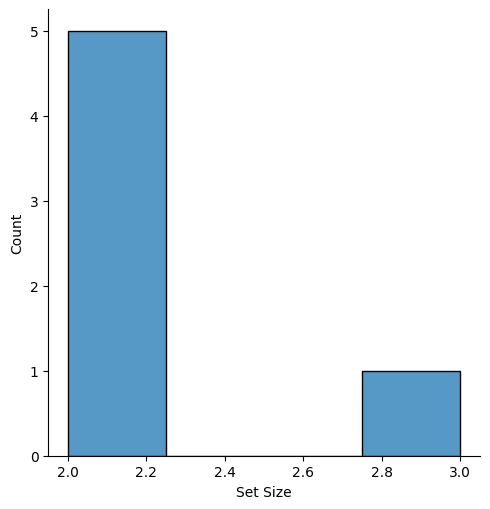

In [45]:
sns.displot([len(s) for s in sets]);
plt.xlabel("Set Size")

In [46]:
counts = [0 for _ in ground_set]

for j in ground_set:
    for s in sets:
        if j in s:
            counts[j] += 1

plt.plot(ground_set, counts)
plt.xticks(ground_set)
plt.ylim(-5, 1400)
plt.ylabel("Number of sets covered by")
plt.xlabel("Point in ground set")

NameError: name 'ground_set' is not defined

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

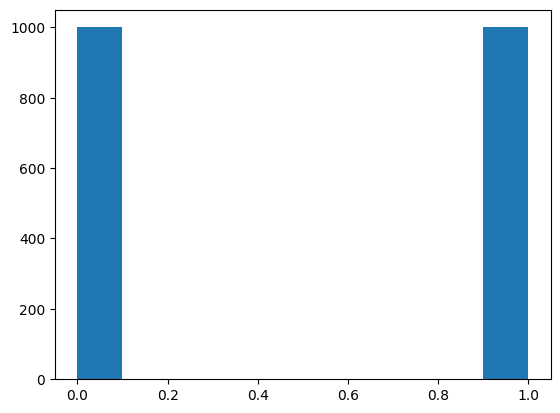

In [ ]:
plt.hist(colors)

# Run Experiments

In [20]:
def run_with_time(func, *args):
    start_time = time.time()
    res = func(*args)
    run_time = time.time() - start_time
    return (res, run_time)

def run_all(n, sets, colors):
    results = {}

    print("SC...")
    results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    print("Naive...")
    results["Naive"] = run_with_time(naive_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("AllPick...")
    results["AllPick"] = run_with_time(all_pick_fair_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))
    print("EffAllPick...")
    results["EffAllPick"] = run_with_time(efficient_pick_set_cover, n, copy.deepcopy(sets), copy.deepcopy(colors))

    return results

In [ ]:
def run_experiments(M, K, N, runs_per_n, colors_prob, set_cover_dist, sizes_list):
    result_df_times = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
    result_df_counts = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}
    result_df_fairness = {"N": [], "SC": [], "Naive": [], "AllPick": [], "EffAllPick": []}

    for n in N:
        for i in range(runs_per_n):
            print("Generating...")
            ground_set, sets, colors = generate(n, M, K,
                                                colors_prob=colors_prob,
                                                set_cover_dist=scipy.stats.norm(loc=n/2, scale=5),
                                                sizes_list=sizes_list)
            print("Running...")
            # Run
            result = run_all(n, sets, colors)

            print(f"{n} in {N}: {i + 1} / {runs_per_n}")

            # Generate Result Dataframe
            result_df_times["N"].append(n)
            result_df_counts["N"].append(n)
            result_df_fairness["N"].append(n)
            for key in result:
                result_df_times[key].append(result[key][1])
                result_df_counts[key].append(len(result[key][0]))
                tmp = np.unique([colors[c] for c in result[key][0]], return_counts=True)[1]
                if len(tmp) == 1:
                    result_df_fairness[key].append(0)
                else:
                    result_df_fairness[key].append(np.min(tmp) / np.max(tmp))


    result_df_times = pd.DataFrame(result_df_times)
    result_df_counts = pd.DataFrame(result_df_counts)
    result_df_fairness = pd.DataFrame(result_df_fairness)

    return result_df_times, result_df_counts, result_df_fairness

result_df_times, result_df_counts, result_df_fairness = run_experiments(M=4000, # Set size
                                                                        K=2, # Number of colors
                                                                        N = [20, 50, 100, 150, 200],
                                                                        runs_per_n=5,
                                                                        colors_prob=np.array([1, 1]) / 4,
                                                                        sizes_list=np.round(np.random.normal(loc=4, scale=1, size=M)),
                                                                        set_cover_dist=scipy.stats.norm(loc=N/2, scale=5))

In [ ]:
# result_df_times.to_csv(f"result_df_generated_times_{K}_{4}_{1}_{5}_{0.3}_{0.3}_{0.3}.csv") # K, loc, scale_1, scale_2
result_df_counts.to_csv(f"result_df_generated_counts_generalized_1000.csv")
# result_df_fairness.to_csv(f"result_df_generated_fairness_{K}_{4}_{1}_{5}_{0.3}_{0.3}_{0.3}.csv")

In [58]:
result_df_times = pd.read_csv(f"result_df_times_popsim_10k.csv", header=0, index_col=0)
result_df_counts = pd.read_csv(f"result_df_counts_popsim_10k.csv", header=0, index_col=0)
result_df_fairness = pd.read_csv("result_df_fairness_popsim_10k.csv", header=0, index_col=0)

# result_df_times = pd.read_csv("resuld_dfs/result_df_times_popsim_small.csv", index_col=0)
# result_df_counts = pd.read_csv("resuld_dfs/result_df_counts_popsim_small.csv", index_col=0)
# result_df_fairness = pd.read_csv("resuld_dfs/result_df_fairness_popsim_small.csv", index_col=0)

result_df_times_2 = pd.read_csv(f"result_df_times_popsim_1k.csv", header=0, index_col=0)
result_df_counts_2 = pd.read_csv(f"result_df_counts_popsim_1k.csv", header=0, index_col=0)
result_df_fairness_2 = pd.read_csv("result_df_fairness_popsim_1k.csv", header=0, index_col=0)

result_df_times = pd.concat([result_df_times, result_df_times_2])
result_df_counts = pd.concat([result_df_counts, result_df_counts_2])
result_df_fairness = pd.concat([result_df_fairness, result_df_fairness_2])
# result_df_counts = pd.read_csv("../synthesized_experiments/result_df_counts_2_ratio.csv", header=0, index_col=0)
# result_df_times = pd.read_csv("../synthesized_experiments/result_df_times_2_ratio.csv", header=0, index_col=0)
# result_df_fairness = pd.read_csv("../synthesized_experiments/result_df_fairness_6_colors.csv", header=0, index_col=0)
# result_df_fairness_red = pd.read_csv(f"../synthesized_experiments/result_df_fairness_red_2_ratio.csv", header=0, index_col=0)
# result_df_fairness_blue = pd.read_csv("../synthesized_experiments/result_df_fairness_blue_2_ratio.csv", header=0, index_col=0)

# result_df_times_naive = pd.read_csv("result_df_generated_times_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_counts_naive = pd.read_csv("result_df_generated_counts_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_fairness_red_naive = pd.read_csv("result_df_generated_fairness_red_generalized_1000_naive.csv", header=0, index_col=0)
# result_df_fairness_blue_naive = pd.read_csv("result_df_generated_fairness_blue_generalized_1000_naive.csv", header=0, index_col=0)

# result_df_times["Naive"] = result_df_times_naive["Naive"]
# result_df_counts["Naive"] = result_df_counts_naive["Naive"]
# result_df_fairness_red["Naive"] = result_df_fairness_red_naive["Naive"]
# result_df_fairness_blue["Naive"] = result_df_fairness_blue_naive["Naive"]

## Generalized Experiments

In [21]:
def run_all(n, sets, colors, ratios):
    results = {}

    print("SC...")
    results["SC"] = run_with_time(standard_set_cover, n, copy.deepcopy(sets))
    print("Greedy...")
    results["Greedy"] = run_with_time(generalized_all_pick, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))
    print("EffGreedy...")
    results["EffGreedy"] = run_with_time(eff_gen_pick, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))
    print("Naive...")
    results["Naive"] = run_with_time(naive_generalized, n, copy.deepcopy(sets), copy.deepcopy(colors), copy.deepcopy(ratios))

    return results

In [23]:
def run_experiments(M, K, N, runs_per_n, colors_prob, set_cover_dist, sizes_list, ratios):
    result_df_times = {"N": [], "Naive": [], "SC": [], "EffGreedy": [], "Greedy": []}
    result_df_counts = {"N": [], "Naive": [], "SC": [], "EffGreedy": [], "Greedy": []}
    result_df_fairness_red = {"N": [], "Naive": [], "SC": [], "EffGreedy": [], "Greedy": []}
    result_df_fairness_blue = {"N": [], "Naive": [], "SC": [], "EffGreedy": [], "Greedy": []}

    for n in N:
        start = time.time()
        for i in range(runs_per_n):
            ground_set, sets, colors = generate(n, M, K,
                                                colors_prob=colors_prob,
                                                set_cover_dist=scipy.stats.norm(loc=n/2, scale=5),
                                                sizes_list=sizes_list)

            # Run
            result = run_all(n, sets, colors, ratios)

            print(f"{n} in {N}: {i + 1} / {runs_per_n}")

            # Generate Result Dataframe
            result_df_times["N"].append(n)
            result_df_counts["N"].append(n)
            # result_df_fairness["N"].append(n)
            result_df_fairness_blue["N"].append(n)
            result_df_fairness_red["N"].append(n)
            for key in result:
                res = list(set(result[key][0]))
                result_df_times[key].append(result[key][1])
                result_df_counts[key].append(len(res))
                tmp = np.unique([colors[c] for c in res], return_counts=True)[1]

                uni = []
                for s in res:
                    uni += sets[s]
                print(f"{key}: {len(set(uni))}")

                if len(tmp) <= 1:
                    print("Less!", key)
                    result_df_fairness_red[key].append(0)
                    result_df_fairness_blue[key].append(0)
                else:
                    tmp_red = [tmp[0] / len(res), ratios[0] / sum(ratios)]
                    tmp_blue = [tmp[1] / len(res), ratios[1] / sum(ratios)]
                    # result_df_fairness[key].append(np.min(tmp) / np.max(tmp))
                    # result_df_fairness[key].append(tmp[0] / tmp[1])
                    result_df_fairness_red[key].append(tmp[0] / len(res))
                    result_df_fairness_blue[key].append(tmp[1] / len(res))

        print("Spent: ", time.time() - start)


    result_df_times = pd.DataFrame(result_df_times)
    result_df_counts = pd.DataFrame(result_df_counts)
    # result_df_fairness = pd.DataFrame(result_df_fairness)
    result_df_fairness_red = pd.DataFrame(result_df_fairness_red)
    result_df_fairness_blue = pd.DataFrame(result_df_fairness_blue)

    return result_df_times, result_df_counts, result_df_fairness_red, result_df_fairness_blue

result_df_times, result_df_counts, result_df_fairness_red, result_df_fairness_blue = run_experiments(M=500,
                                                                        K = 2,
                                                                        N = [30],
                                                                        runs_per_n=4,
                                                                        colors_prob=np.array([0.66, 0.34]),
                                                                        sizes_list=np.round(np.random.normal(loc=4, scale=1, size=M)),
                                                                        set_cover_dist=scipy.stats.norm(loc=10, scale=5),
                                                                        ratios=[0.6, 0.3]
                                                                        )

SC...
Greedy...
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
EffGreedy...
Naive...
30 in [30]: 1 / 4
SC: 30
Greedy: 30
EffGreedy: 30
Naive: 30
SC...
Greedy...
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([325, 325, 175], [0, 0, 0], [0, 0, 1])
end
EffGreedy...
Naive...
30 in [30]: 2 / 4
SC: 30
Greedy: 28
EffGreedy: 30
Naive: 30
SC...
Greedy...
Start of comb: ([324, 324, 176], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([324, 324, 176], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([324, 324, 176], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([324, 324, 176], [0, 0, 0], [0, 0, 1])
end
Start of comb: ([324,

In [104]:
# Persist
result_df_times.to_csv("../synthesized_experiments/result_df_times_1_ratio.csv")
result_df_counts.to_csv("../synthesized_experiments/result_df_counts_1_ratio.csv")
result_df_fairness_red.to_csv("../synthesized_experiments/result_df_fairness_red_1_ratio.csv")
result_df_fairness_blue.to_csv("../synthesized_experiments/result_df_fairness_blue_1_ratio.csv")

NameError: name 'result_df_fairness_red' is not defined

# Visualization

In [53]:
markers = {
    "SC": "o",
    "Naive": "^",
    # "AllPick": "s"
    "EffAllPick": "*"
}

names = {
    "SC": "SC",
    "Naive": "Naive",
    # "AllPick": "AllPick"
    "EffAllPick": "EffAllPick"
}

# algs = ["SC", "Naive", "AllPick", "EffAllPick"]
algs = ["SC", "Naive", "EffAllPick"]

# markers = {
#     "SC": "o",
#     "Naive": "^",
#     "EffGreedy": "s"
#     # "EffAllPick": "*"
# }

# names = {
#     "SC": "SC",
#     "Naive": "Naive",
#     "EffGreedy": "EffGFSC"
#     # "EffAllPick": "EffAllPick"
# }

# algs = ["SC", "Naive", "EffGreedy"]

In [39]:
result_df_times.head()

,N,Naive,SC,EffGreedy
0,50,0.123564,0.100180,0.127050
1,50,0.122977,0.045526,0.124970
2,50,0.181387,0.044996,0.131921
3,50,0.179859,0.045299,0.115058
4,50,0.183182,0.045752,0.125093


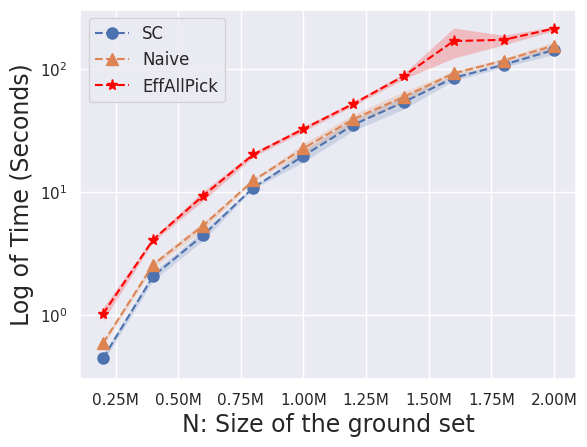

In [63]:
sns.set()

import matplotlib.ticker as ticker

means = result_df_times.groupby("SetSize").mean()
x = means.index.values
stds = result_df_times.groupby("SetSize").std()
mins = result_df_times.groupby("SetSize").min()
maxs = result_df_times.groupby("SetSize").max()

x = x * 100

for alg in algs:
    if alg == "SetSize":
        continue
    if alg == "EffAllPick":
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8, color="red")
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2, color="red", linewidth=0.0)    
    else:
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2)

plt.legend(loc="upper left", prop={'size': 12})
plt.yscale("log")
plt.xlabel("N: Size of the ground set", fontsize=17)
plt.ylabel("Log of Time (Seconds)", fontsize=17)

def millions(x, pos):
    return '%1.2fM' % (x * 1e-6)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# plt.savefig('times_popsim_large.png', bbox_inches='tight')
# plt.savefig('times_popsim_small.eps', format="eps")

plt.show()

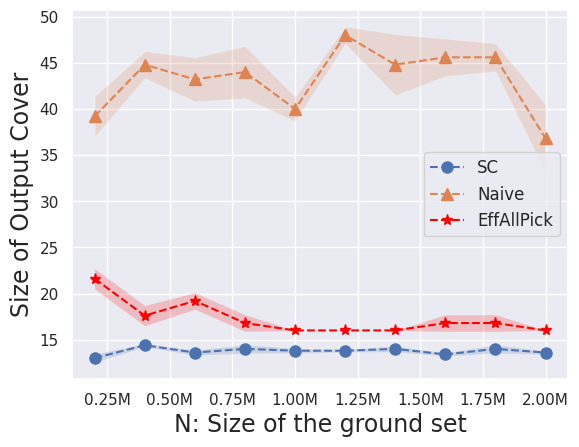

In [66]:
d = copy.deepcopy(result_df_counts)

sns.set()
means = d.groupby("SetSize").mean()
x = means.index.values
stds = d.groupby("SetSize").std()
mins = d.groupby("SetSize").min()
maxs = d.groupby("SetSize").max()

x = x * 100

for alg in algs:
    if alg == "SetSize":
        continue
    if alg == "EffAllPick":
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8, color="red")
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2, color="red", linewidth=0.0)    
    else:
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
        plt.fill_between(x, means[alg] - stds[alg] / 3, means[alg] + stds[alg] / 3, alpha=0.2)

plt.legend(loc="center right", prop={'size': 12})
plt.xlabel("N: Size of the ground set", fontsize=17)
plt.ylabel("Size of Output Cover", fontsize=17)

def millions(x, pos):
    return '%1.2fM' % (x * 1e-6)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# plt.savefig('counts_popsim_large.png', bbox_inches='tight')
# plt.savefig('counts_popsim_small.eps', format="eps")

plt.show()

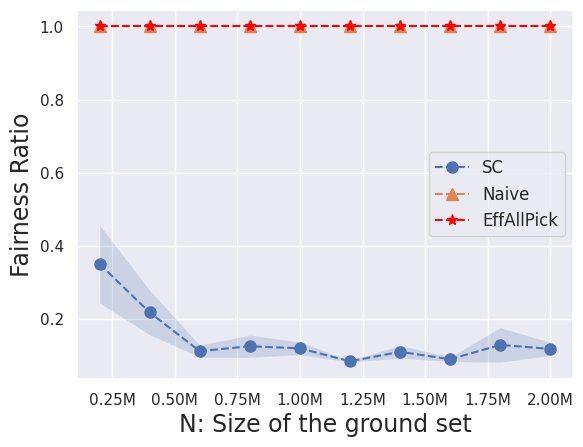

In [69]:
d = copy.deepcopy(result_df_fairness)
sns.set()
means = d.groupby("SetSize").mean()
x = means.index.values
stds = d.groupby("SetSize").std()
mins = d.groupby("SetSize").min()
maxs = d.groupby("SetSize").max()

x = x * 100

for alg in algs:
    if alg == "SetSize":
        continue
    # if alg == "AllPick":
    #     continue
    if alg == "EffAllPick":
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8, color="red")
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2, color="red", linewidth=0.0)    
    else:
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2)

plt.legend(loc="center right", prop={'size': 12})
plt.xlabel("N: Size of the ground set", fontsize=17)
plt.ylabel("Fairness Ratio", fontsize=17)

def millions(x, pos):
    return '%1.2fM' % (x * 1e-6)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# plt.savefig('fairness_popsim_large.png', bbox_inches='tight')
# plt.savefig('fairness_popsim_small.eps', format="eps")

plt.show()

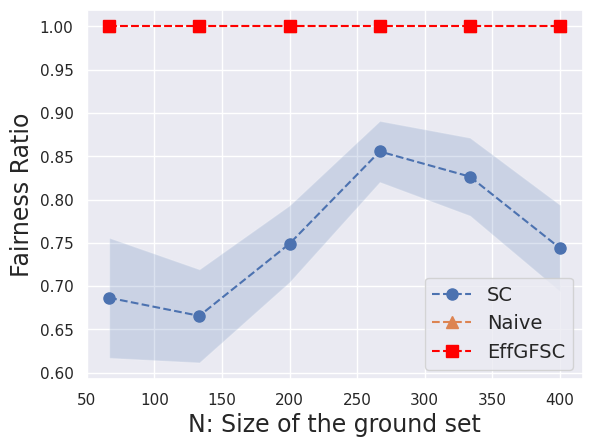

In [48]:
# result_df_fairness_blue[result_df_fairness_blue["N"] == 30]["fairness"]
d = copy.deepcopy(result_df_fairness_red)
d2 = copy.deepcopy(result_df_fairness_blue)

for alg in d.keys():
    d[alg] = d[alg] / 0.75
    tmp = d2[alg] / (1 - 0.75)
    d[alg] = np.minimum(tmp, d[alg])

sns.set()
means = d.groupby("N").mean()
x = means.index.values
stds = d.groupby("N").std()
mins = d.groupby("N").min()
maxs = d.groupby("N").max()


for alg in algs:
    if alg == "N":
        continue
    if alg == "EffGreedy":
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8, color="red")
        plt.fill_between(x, means[alg] - stds[alg] / 2, means[alg] + stds[alg] / 2, alpha=0.2, color="red", linewidth=0.0)    
    else:
        plt.plot(x, means[alg], label=names[alg], marker=markers[alg], linestyle='--', markersize=8)
        plt.fill_between(x, means[alg] - stds[alg] / math.sqrt(20), means[alg] + stds[alg] / math.sqrt(20), alpha=0.2)

plt.legend(loc="lower right", prop={'size': 14})
plt.xlabel("N: Size of the ground set", fontsize=17)
plt.ylabel("Fairness Ratio", fontsize=17)

# plt.savefig('fairness_2_ratio_extended.png', bbox_inches='tight')
# plt.savefig('fairness_2_ratio_extended.eps', format="eps")

plt.show()